### Comparing ice melt from APP-x and CS2SMOS

- The data is imported and regridded onto EASE. This includes:
    - APP-x data, the data generated by the ice_abs_mo.py script is imported
    - CS2SMOS data, the last weekly mean in April and the first weekly mean in October for years 2011-2017. This is regridded from EASE2 to EASE
    - Retreat data, from the NSIDC arctic seasonal trends dataset. This is kept in polar sterographic projection as it simply plotted over the APP-x/CS2SMOS data and not used in calculations.
    - Ice motion data, the mean weekly ice motion vectors from NSIDC are imported between mid-April and mid-October due to CS2SMOS temporal range. These are on EASE grid.
- Four plots are produced:
    - Two for the years of APP-x and CS2SMOS difference and with retreat contours overlain
    - Two with streamplot of mean ice motion

In [1]:
from scipy.interpolate import griddata
import pyproj as proj
import numpy as np

# Robbie's regridding function

args = proj.Proj(proj="laea", lat_0=90, lon_0=0, datum="WGS84", units="m")

crs_wgs = proj.Proj(init='epsg:4326')

def regrid(data_in,
           lon_in,
           lat_in,
           lon_out,
           lat_out,
           method='nearest'):

    xout, yout = proj.transform(crs_wgs, args, np.array(lon_out),np.array(lat_out))

    xin, yin = proj.transform(crs_wgs, args, np.array(lon_in),np.array(lat_in))

    output = griddata((xin.ravel(),yin.ravel()),
                    np.array(data_in).ravel(),
                    (xout,yout),
                    method=method)
    
    return(output)


# Import EASE grid lon and lat data from example netcdf files for regridding

import xarray as xr

EASE_data = xr.open_dataset('/Users/farrerowsleybrown/Desktop/project/code/grids/EASE_grid.nc')
EASE_lon, EASE_lat = EASE_data.lon.data, EASE_data.lat.data

EASE2_data = xr.open_dataset('/Users/farrerowsleybrown/Desktop/project/code/grids/EASE2_grid.nc')
EASE2_lon, EASE2_lat = EASE2_data.lon.data, EASE2_data.lat.data

In [2]:
# Import energy absorption data by sea ice from app-x

import os
import glob

files_ice = sorted(glob.glob('/Users/farrerowsleybrown/Desktop/project/code/data/my_data/'+
                         'ice_abs_mo/ice_abs_mo*.nc'))

ds_ice = xr.open_mfdataset(files_ice, concat_dim='year', combine='nested').load()

# divide by density and latent heat of fusion for ice thickness change
appx_thick_diff = ds_ice / (917*334000)

appx_thick_diff = appx_thick_diff.net[29:]



In [3]:
# Fetch cs2smos thickness data

os.chdir('/Users/farrerowsleybrown/Desktop/project/code/data/cs2smos')

files = sorted(glob.glob('*/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2*.nc'))
cs2smos = xr.open_mfdataset(files, concat_dim='time', combine='nested')
cs2smos_thick = cs2smos.analysis_sea_ice_thickness.load().fillna(0)
cs2smos_sic = cs2smos.sea_ice_concentration.load().fillna(0)
cs2smos.close()

# assuming the thickness is the thickness of the ice that's there, not mean including open water
thick_1 = cs2smos_thick.groupby('time.year').first() * cs2smos_sic.groupby('time.year').first()/100
thick_2 = cs2smos_thick.groupby('time.year').last() * cs2smos_sic.groupby('time.year').last()/100
cs2smos_thick_diff2 = thick_1 - thick_2


/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [4]:
# Create new xr dataset to put cs2smos data thats been regridded to EASE (from EASE2)

cs2smos_thick_diff = xr.Dataset()
cs2smos_thick_diff = cs2smos_thick_diff.assign_coords(appx_thick_diff.coords)
cs2smos_thick_diff['thick_diff'] = (('year', 'columns', 'rows'), np.full((7,361,361), np.nan)) # 7 years

dat = np.array([])

for i in range(0,7):
    dat = np.append(dat, 
                    regrid(cs2smos_thick_diff2[i], EASE2_lon, EASE2_lat, EASE_lon, EASE_lat))

dat = dat.reshape((7,361,361))
cs2smos_thick_diff['thick_diff'] = (('year', 'columns', 'rows'), dat)

In [5]:
# Import SIC data to plots the september extent

import numpy.ma as ma

file_path = '/Users/farrerowsleybrown/Desktop/project/code/data/my_data/sic_EASE_nc/'

lon, lat = EASE_lon, EASE_lat
# prep lon values for contouring
lon_greater = ma.masked_greater(lon, -0.1)
lon_lesser = ma.masked_less(lon, 0)
# apply to other arrays
lat_greater = ma.MaskedArray(lat, mask=lon_greater.mask)
lat_lesser = ma.MaskedArray(lat, mask=lon_lesser.mask)

def sep_sic(year):
    data = xr.open_dataset(file_path+'sic_EASE_'+str(year)+'.nc').load()
    data.close()
    sep_sic = data.sic[139:-15].mean(dim='dayofyear')*100
    
    # fetch data for plotting from 'anom_vol' xarray dataset
    sep_sic_greater = ma.MaskedArray(sep_sic, mask=lon_greater.mask)
    sep_sic_lesser = ma.MaskedArray(sep_sic, mask=lon_lesser.mask)
    
    return sep_sic_greater, sep_sic_lesser


/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


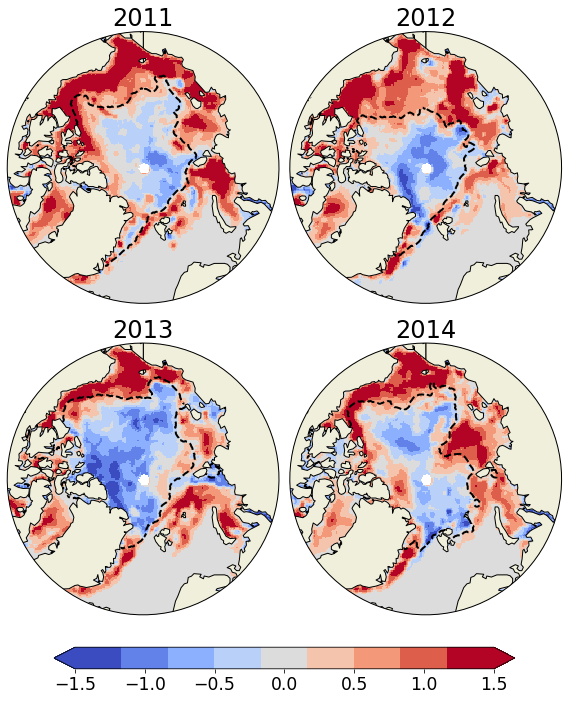

In [23]:
# Making the plots

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import calendar

%matplotlib inline

# Make figure
fig = plt.figure(figsize=(8, 10))

# Number of subplots and projection
columns = 2
rows = 2
projection = ccrs.LambertAzimuthalEqualArea(central_latitude=90)

base = plt.cm.get_cmap(plt.cm.coolwarm)
N=9
color_list = base(np.linspace(0, 1, N))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N)

# For making lovely round plots, not square
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# For loop to iterate through the subplots from the starting year below:
year = 2011
for i in range(1, columns*rows +1):
    
    # add a subplot into the array of plots
    ax = fig.add_subplot(rows, columns, i, projection=projection)
    
    # map features: round, land showing, title and extent of plot (90N to 66N)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_title(year+i-1, fontsize=24)
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
    
    plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year+i-1}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year+i-1}).rolling(columns=3).mean().rolling(rows=3).mean()
    
    # plot colormesh of the app-x/cs2smos difference
    cp = ax.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)
    
    sep_sic_greater, sep_sic_lesser = sep_sic(year+i-1)
    
    levels = np.linspace(15,15,1)
    
    ct1 = ax.contour(lon_greater, lat_greater,
                     sep_sic_greater,
                     transform=ccrs.PlateCarree(),
                     levels=levels,
                     colors='black',
                     linewidths=2,
                     linestyles='dashed',
                     zorder=2)
    
    ct2 = ax.contour(lon_lesser, lat_lesser,
                     sep_sic_lesser,
                     transform=ccrs.PlateCarree(),
                     levels=levels,
                     colors='black',
                     linewidths=2,
                     linestyles='dashed',
                     zorder=2)
    
    #ax.clabel(ct1, ct1.levels, inline_spacing=0, fmt='%1.0f', fontsize=12)
    #ax.clabel(ct2, ct2.levels, inline_spacing=0, fmt='%1.0f', fontsize=12)
    
# Adjusting the subplots to make room for the colorbar
fig.subplots_adjust(top=1, bottom=0.15, left=0.3, right=1, hspace=0.15, wspace=0.25)

# Adding the colorbar
cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.03])
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal',extend='both')
cbar.ax.tick_params(labelsize='xx-large')
#cbar.set_label(r'CS2SMOS $-$ APP-x Summer Ice Melt (m)', fontsize=16) 

fig.tight_layout(h_pad = 0.5, rect=[0,0,1,1])

plt.savefig('/Users/farrerowsleybrown/Desktop/project/thesis/'+
            'figures/2011-2014_extentcontour.png',
            dpi=300, bbox_inches='tight')

plt.show()


/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


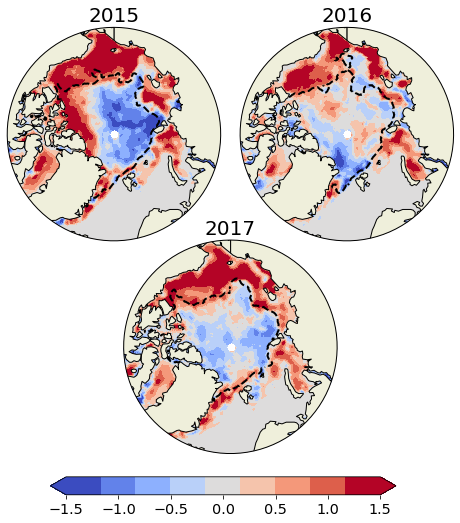

In [26]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


# kit for making circular boundaries
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# make figure
fig  = plt.figure(figsize=(8,10), constrained_layout=False)
gs = fig.add_gridspec(4, 4)


# YEAR 1
year = 2015
ax1 = fig.add_subplot(gs[:3, :2], projection= ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2)
ax1.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.set_title(year, fontsize=20)

sep_sic_greater, sep_sic_lesser = sep_sic(year)

ct1 = ax1.contour(lon_greater, lat_greater,
                  sep_sic_greater,
                  levels=levels,
                  transform=ccrs.PlateCarree(),
                  zorder=1,
                  linewidths=2,
                  linestyles='dashed',
                  colors='black')

ct2 = ax1.contour(lon_lesser, lat_lesser,
                  sep_sic_lesser, \
                  levels=levels, \
                  transform=ccrs.PlateCarree(),
                  zorder=1,
                  linewidths=2,
                  linestyles='dashed',
                  colors='black')

plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean()

cp1 = ax1.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)


# YEAR 2
year = 2016
ax2 = fig.add_subplot(gs[:3, 2:4], projection= ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2)
ax2.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.set_title(year, fontsize=20)

sep_sic_greater, sep_sic_lesser = sep_sic(year)

ct3 = ax2.contour(lon_greater, lat_greater,
                  sep_sic_greater,
                  levels=levels,
                  transform=ccrs.PlateCarree(),
                  zorder=1,
                  linewidths=2,
                  linestyles='dashed',
                  colors='black')

ct4 = ax2.contour(lon_lesser, lat_lesser,
                  sep_sic_lesser, \
                  levels=levels, \
                  transform=ccrs.PlateCarree(),
                  zorder=1,
                  linewidths=2,
                  linestyles='dashed',
                  colors='black')

plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean()

cp2 = ax2.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)


# YEAR 3
year = 2017
ax3 = fig.add_subplot(gs[2:4, 1:3], projection= ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax3.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2)
ax3.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax3.set_boundary(circle, transform=ax3.transAxes)
ax3.set_title(year, fontsize=20)

sep_sic_greater, sep_sic_lesser = sep_sic(year)

ct5 = ax3.contour(lon_greater, lat_greater,
                  sep_sic_greater,
                  levels=levels,
                  transform=ccrs.PlateCarree(),
                  zorder=1,
                  linewidths=2,
                  linestyles='dashed',
                  colors='black')

ct6 = ax3.contour(lon_lesser, lat_lesser,
                  sep_sic_lesser, \
                  levels=levels, \
                  transform=ccrs.PlateCarree(),
                  zorder=1,
                  linewidths=2,
                  linestyles='dashed',
                  colors='black')

plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean()


cp3 = ax3.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)


cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.025])
cbar = fig.colorbar(cp1, cax=cbar_ax, orientation='horizontal',extend='both')
cbar.ax.tick_params(labelsize='x-large')
#cbar.set_label(r'CS2SMOS $-$ APP-x Summer Ice Melt (m)', fontsize=20) 


plt.savefig('/Users/farrerowsleybrown/Desktop/project/thesis'+
            '/figures/2015-2017_extentcontour.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [28]:

def motion_data(year):
    os.chdir('/Users/farrerowsleybrown/Desktop/project/code/data/nsidc_imv/')
    
    files = sorted(glob.glob('icemotion_weekly_nh_25km_*.nc'))
    
    ds = xr.open_dataset(files[year-2011])#, concat_dim='time', combine='nested')
    ds['time'] = ds.time.indexes['time'].to_datetimeindex()
    
    x = ds.x.data
    y = ds.y.data
    u = ds.u[14:37].mean(dim='time').data
    v = ds.v[14:37].mean(dim='time').data
    
    return x, y, u, v


/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: R

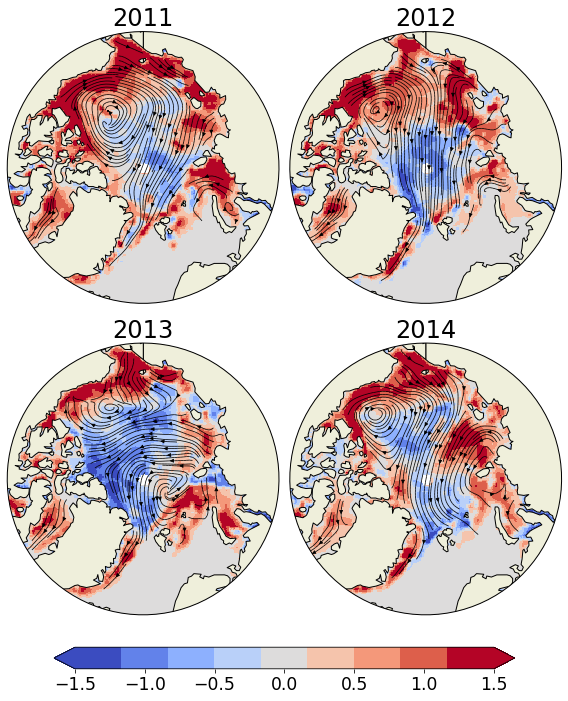

In [31]:
# Make figure
fig = plt.figure(figsize=(8, 10))

# Number of subplots and projection
columns = 2
rows = 2
projection = ccrs.LambertAzimuthalEqualArea(central_latitude=90)

# For making lovely round plots, not square
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# For loop to iterate through the subplots from the starting year below:
year = 2011
for i in range(1, columns*rows +1):
    
    # add a subplot into the array of plots
    ax = fig.add_subplot(rows, columns, i, projection=projection)
    
    # map features: round, land showing, title and extent of plot (90N to 66N)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_title(year+i-1, fontsize=24)
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
    
    plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year+i-1}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year+i-1}).rolling(columns=3).mean().rolling(rows=3).mean()
    
    # plot colormesh of the app-x/cs2smos difference
    cp = ax.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)
    
    x, y, u, v = motion_data(year+i-1)
    
    ax.streamplot(x, y, u, v, density=3,
                  color='black',
                  linewidth=0.75,
                  arrowsize = 0.75,
                  zorder=2)
    
# Adjusting the subplots to make room for the colorbar
fig.subplots_adjust(top=1, bottom=0.15, left=0.3, right=1, hspace=0.15, wspace=0.25)

# Adding the colorbar
cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.03])
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal',extend='both')
cbar.ax.tick_params(labelsize='xx-large')
#cbar.set_label(r'CS2SMOS $-$ APP-x Summer Ice Melt (m)', fontsize=16) 

fig.tight_layout(h_pad = 0.5, rect=[0,0,1,1])

plt.savefig('/Users/farrerowsleybrown/Desktop/project/thesis/'+
           'figures/2011-2014_motion.png',
            dpi=300, bbox_inches='tight')

plt.show()

/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys
/Users/farrerowsleybrown/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: R

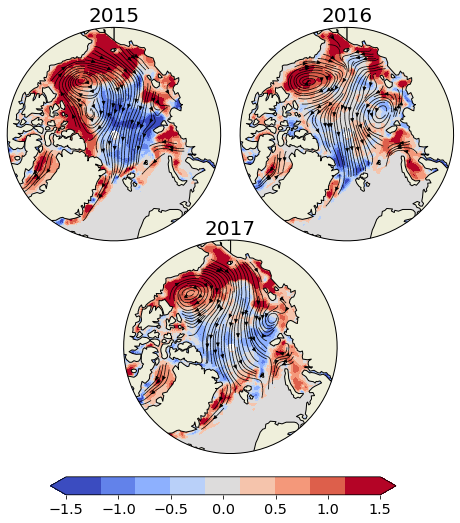

In [33]:
fig  = plt.figure(figsize=(8,10), constrained_layout=False)
gs = fig.add_gridspec(4, 4)


# YEAR 1
year = 2015
ax1 = fig.add_subplot(gs[:3, :2], projection= ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2)
ax1.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.set_title(year, fontsize=20)

x, y, u, v = motion_data(year)
    
sp1 = ax1.streamplot(x, y, u, v, density=3,
                  color='black',
                  linewidth=0.75,
                  arrowsize = 0.75,
                  zorder=2)

plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean()

cp1 = ax1.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)



# YEAR 2
year = 2016
ax2 = fig.add_subplot(gs[:3, 2:4], projection= ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2)
ax2.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.set_title(year, fontsize=20)

x, y, u, v = motion_data(year)

sp2 = ax2.streamplot(x, y, u, v, density=3,
                  color='black',
                  linewidth=0.75,
                  arrowsize = 0.75,
                  zorder=2)

plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean()

cp2 = ax2.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)


# YEAR 3
year = 2017
ax3 = fig.add_subplot(gs[2:4, 1:3], projection= ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax3.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2)
ax3.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
ax3.set_boundary(circle, transform=ax3.transAxes)
ax3.set_title(year, fontsize=20)

x, y, u, v = motion_data(year)

sp3 = ax3.streamplot(x, y, u, v, density=3,
                  color='black',
                  linewidth=0.75,
                  arrowsize = 0.75,
                  zorder=2)

plot_data = cs2smos_thick_diff.thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean() -\
    appx_thick_diff.sel({'year':year}).rolling(columns=3).mean().rolling(rows=3).mean()

cp3 = ax3.pcolormesh(EASE_lon, EASE_lat,
                       plot_data.where(ds_ice.latitude.load()<89),
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=-1.5, vmax=1.5,
                       zorder=0)


cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.025])
cbar = fig.colorbar(cp1, cax=cbar_ax, orientation='horizontal',extend='both')
cbar.ax.tick_params(labelsize='x-large')


plt.savefig('/Users/farrerowsleybrown/Desktop/project/thesis/figures/'+
            '2015-2017_motion.png',
            dpi=300, bbox_inches='tight')
plt.show()